# In this notebook, we aim to create a model to predict which passengers would survive/die in the Titanic Crash

**The outline of the notebook will be:**

**1) Getting the dataset**

**2) Exploratory Data Analysis**

**3) Feature Engineering**

**4) Building Models**

**5) Submission**

**Importing relevant libraries for explaratory analysis**

In [ ]:
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

# 1) Getting the dataset

In [ ]:
train=pd.read_csv("../input/train.csv")
Test=pd.read_csv("../input/test.csv")

In [ ]:
train.tail()

# 2) Exploratory Data Analysis

**Data dictionary and notes from https://www.kaggle.com/c/titanic/data**

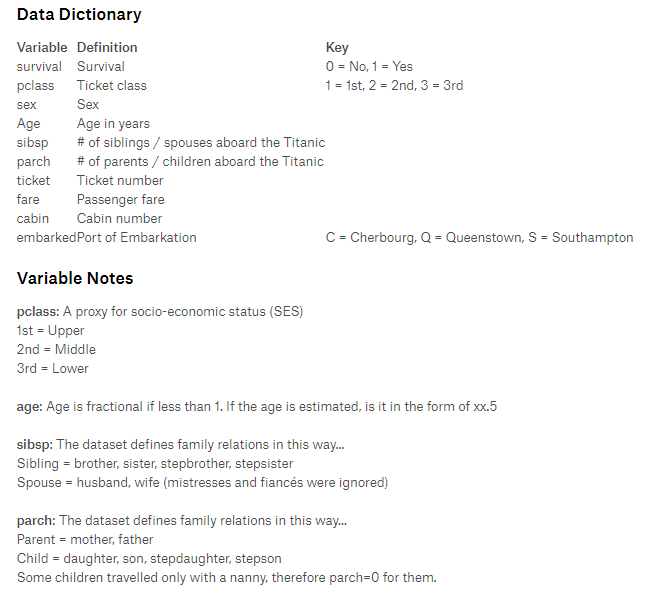

In [ ]:
train.info()

In [ ]:
Test.info()

# 2.1 Plotting and visualising the distributions of different variables

In [ ]:
train["Survived"].value_counts().plot(kind="bar")
train["Survived"].value_counts()

Our dataset shows that there were 549 passengers who died while 342 survived.

In [ ]:
train["Age"].hist(width=6)

In [ ]:
train["Sex"].value_counts().plot(kind="bar")

In [ ]:
labels="Cherbourg","Queenstown","Southampton"
sizes=[sum(train["Embarked"]=="C"),sum(train["Embarked"]=="Q"),sum(train["Embarked"]=="S")]
colors=["yellow","aqua","lime"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

# 2.2 Comparing survival rates among different variables

In [ ]:
def survival_stacked_bar(variable):
    Died=train[train["Survived"]==0][variable].value_counts()/len(train["Survived"]==0)
    Survived=train[train["Survived"]==1][variable].value_counts()/len(train["Survived"]==1)
    data=pd.DataFrame([Died,Survived])
    data.index=["Did not survived","Survived"]
    data.plot(kind="bar",stacked=True,title="Percentage")
    return data.head()

In [ ]:
survival_stacked_bar("Sex")

We can see from the plot that females tend to survived more than males.

In [ ]:
survival_stacked_bar("Pclass")

We can see from the plot that people of higher social-economic status (Pclass = 1) tend to have a higher chance of surviving compared to those of lower social-economic status.

In [ ]:
survival_stacked_bar("Embarked")

We can see that a person embarked on Cherbourg Port has a higher chance of surviving compared to those embarked on Southampton Port and Queenstown Port.

In [ ]:
survival_stacked_bar("SibSp")

In [ ]:
survival_stacked_bar("Parch")

We can see that passengers that boarded alone have a lower survival rate compared to those that board with parents or children.

# 2.3 Correlation heatmap of all variables

In [ ]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True, linewidths=0.5, fmt= '.2f',ax=ax)

We can see from the plots above and from the  correlation heatmap the more prominent relationship between:
-  **"sex" and "survived"**
    -  As shown in the plots above, it is quite obvious that females tend to have a higher survival rate than males
-  **"Pclass" and "fare"**
    -  A passenger with a higher social-economic status would most likely pay a higher fare, hence the relatively high correlation between the 2 variables


# 3. Feature Engineering

**Combining the 2 datasets**

In [ ]:
traintestdata=pd.concat([train,Test])
traintestdata.shape

## 3.1 "Sex" Mapping and Encoding

In [ ]:
sex_map={"male":1,"female":0}
train["Sex"]=train["Sex"].map(sex_map)
Test["Sex"]=Test["Sex"].map(sex_map)
survival_stacked_bar("Sex")

# 3.2 Name/Title mapping

In [ ]:
train.insert(value=train.Name.map(lambda name: name.split(",")[1].split(".")[0].strip()),loc=12,column="Title")
Test.insert(value=Test.Name.map(lambda name: name.split(",")[1].split(".")[0].strip()),loc=11,column="Title")

We then assign social status titles to them for more in-depth analysis.

In [ ]:
title_map={"Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir" : "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess":"Royalty",
            "Dona": "Royalty",
            "Mme":  "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr" : "Mr",
            "Mrs" : "Mrs",
            "Miss" : "Miss",
            "Master" : "Master",
            "Lady" : "Royalty"}
train["Title"]=train.Title.map(title_map)
Test["Title"]=Test.Title.map(title_map)

# 3.3 Checking for missing values in dataset:

In [ ]:
for i in train.columns:
    print (i + ": "+str(sum(train[i].isnull()))+" missing values")

In [ ]:
for i in Test.columns:
    print (i + ": "+str(sum(Test[i].isnull()))+" missing values")

**3.3.1 Dealing with Age (Missing values)**
It is not very accurate to replace the missing values of age with the mean or median. As such, looking at the correlation heatmap above, the 2 factors most associated with age is Pclass and SibSp. Hence, I would first differentiate our dataset by their social-economic status and number of siblings/spouses they are on board with. I would then use the median of each subset as the replacement for the respective missing values. 

In [ ]:
train_set_1=train.groupby(["Pclass","SibSp"])
train_set_1_median=train_set_1.median()
train_set_1_median

In [ ]:
Test_set_1=Test.groupby(["Pclass","SibSp"])
Test_set_1_median=Test_set_1.median()
Test_set_1_median

In the following funcion, the medians of each group would be used to replace missing values in the "Age" based on their groups (Pclass and SibSp) 

In [ ]:
def fill_age(dataset,dataset_med):
    for x in range(len(dataset)):
        if dataset["Pclass"][x]==1:
            if dataset["SibSp"][x]==0:
                return dataset_med.loc[1,0]["Age"]
            elif dataset["SibSp"][x]==1:
                return dataset_med.loc[1,1]["Age"]
            elif dataset["SibSp"][x]==2:
                return dataset_med.loc[1,2]["Age"]
            elif dataset["SibSp"][x]==3:
                return dataset_med.loc[1,3]["Age"]
        elif dataset["Pclass"][x]==2:
            if dataset["SibSp"][x]==0:
                return dataset_med.loc[2,0]["Age"]
            elif dataset["SibSp"][x]==1:
                return dataset_med.loc[2,1]["Age"]
            elif dataset["SibSp"][x]==2:
                return dataset_med.loc[2,2]["Age"]
            elif dataset["SibSp"][x]==3:
                return dataset_med.loc[2,3]["Age"]
        elif dataset["Pclass"][x]==3:
            if dataset["SibSp"][x]==0:
                return dataset_med.loc[3,0]["Age"]
            elif dataset["SibSp"][x]==1:
                return dataset_med.loc[3,1]["Age"]
            elif dataset["SibSp"][x]==2:
                return dataset_med.loc[3,2]["Age"]
            elif dataset["SibSp"][x]==3:
                return dataset_med.loc[3,3]["Age"]
            elif dataset["SibSp"][x]==4:
                return dataset_med.loc[3,4]["Age"]
            elif dataset["SibSp"][x]==5:
                return dataset_med.loc[3,5]["Age"]
            elif dataset["SibSp"][x]==8:
                return dataset_med.loc[3]["Age"].median()  #I used the median age of Pclass=3 as a replacement as there is no median value for SibSp=8 in training dataset


In [ ]:
train["Age"]=train["Age"].fillna(fill_age(train,train_set_1_median))
Test["Age"]=Test["Age"].fillna(fill_age(Test,Test_set_1_median))

**3.3.2 Dealing with Cabin (Missing values)**
Since the cabin location would logically affect their ability to evacuate and survive, it is also not appropriate to assign the missing cabin values randomly. Instead, I would assign them **Cabin U (U for unknown)**. 

In [ ]:
traintestdata.Cabin.unique()

In [ ]:
train["Cabin"]=train["Cabin"].fillna("U")
Test["Cabin"]=Test["Cabin"].fillna("U")
train["Cabin"]=train["Cabin"].map(lambda x: x[0])
Test["Cabin"]=Test["Cabin"].map(lambda x: x[0])

We create a column for each cabin and insert the value "1" if the passenger belongs to that cabin and "0" if the passenger do not belong to it. We only create columns for cabin A,B,C,D,E,F,G,T and **LEFT OUT CABIN U** in the columns created in order to prevent collinearity. Passengers in Cabin U would have values "0" for all the cabins columns (A,B,C,D,E,F,G,T).


In [ ]:
def new_cabin_features(dataset):
    dataset["Cabin A"]=np.where(dataset["Cabin"]=="A",1,0)
    dataset["Cabin B"]=np.where(dataset["Cabin"]=="B",1,0)
    dataset["Cabin C"]=np.where(dataset["Cabin"]=="C",1,0)
    dataset["Cabin D"]=np.where(dataset["Cabin"]=="D",1,0)
    dataset["Cabin E"]=np.where(dataset["Cabin"]=="E",1,0)
    dataset["Cabin F"]=np.where(dataset["Cabin"]=="F",1,0)
    dataset["Cabin G"]=np.where(dataset["Cabin"]=="G",1,0)
    dataset["Cabin T"]=np.where(dataset["Cabin"]=="T",1,0)  #Cabin U is when the rest of cabins are 0
    

In [ ]:
new_cabin_features(train)
new_cabin_features(Test)

**3.3.3 Dealing with Embarked (Missing values)**

Since there's only 2 missing values in "Embarked", I would just replace it with "Southampton" as a huge majority (72.4%) embarked on Southampton.

In [ ]:
train["Embarked"]=train["Embarked"].fillna("S")

Similar to "Cabin", we created 2 columns (Embarked S and Embarked C), leaving out Embarked Q to prevent collinearity.

In [ ]:
def new_embark_features(dataset):
    dataset["Embarked S"]=np.where(dataset["Embarked"]=="S",1,0)
    dataset["Embarked C"]=np.where(dataset["Embarked"]=="C",1,0)  #Embarked on Q is when the rest of embarked are 0

In [ ]:
new_embark_features(train)
new_embark_features(Test)

**3.3.4 Dealing with Fare (Missing values)**
Since there's only 1 missing value in "Fare" in the test set, I would just replace it with the mean.

In [ ]:
Test["Fare"]=Test["Fare"].fillna(np.mean(Test["Fare"]))

# 3.4 Encoding categorical features

**3.4.1 Encoding Titles** 

In [ ]:
title_map_2={'Mr':1, 
           'Mrs':1, 
           'Miss':1,
           'Master':2,
           'Officer':3,
           'Royalty':4}
train["Title"]=train["Title"].map(title_map_2)
Test["Title"]=Test["Title"].map(title_map_2)

# 3.5 Adding new variable (Family size)

I use this equation (**SibSp + Parch + 1(ownself)**) to calculate the total family size that the person travelled with on board.

In [ ]:
train["FamilySize"]=train["SibSp"]+train["Parch"]+1
Test["FamilySize"]=Test["SibSp"]+Test["Parch"]+1

In [ ]:
train.info()

**Now that all the variables have been encoded and there are no missing values, we are ready to build our models.** 

# 4. Building Models

**Importing libraries for classification models**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.cross_validation import train_test_split
import scikitplot as skplt
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
from sklearn.metrics import roc_curve, auc

**We will first remove "Name","Ticket","PassengerId","Embarked","Cabin" since they would play no role in helping our model. ** (Cabin and Embarked has already been encoded into different columns)

In [ ]:
train.drop(["Name","Ticket","PassengerId","Embarked","Cabin"],inplace=True,axis=1)
Test.drop(["Name","Ticket","Embarked","Cabin"],inplace=True,axis=1)
train.tail()

**We will first sort out our training and test set.**

In [ ]:
x=train.drop(["Survived"],axis=1)
y=train["Survived"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

**We will use cross validation to test our models**

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

We first create these functions to allow us the ease of computing relevant scores and plotting of plots.

In [ ]:
def acc_score(model):
    return np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy"))

In [ ]:
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Dead","Predicted Survived"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Dead","Predicted Survived"]
    cm.index=["Actual Dead","Actual Survived"]
    cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2)
    return cm

In [ ]:
def importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

In [ ]:
def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

Note that in the above function "plt_roc_curve", there is a "has_proba" argument. This is because although most classifiers can produce probability of instances being in each class, some classifiers (like Support Vector Machine) do not directly provide probabilities, hence for those kind of classifiers, we use .decision_function to give the distance to the separating hyperplanes.

Plotting confusion matrix and ROC curves are important to let us understand and visualise the respective models' prediction accuracy. 

For **Confusion matrix:**
-  **We can observe and analyse the FALSE POSITIVE and FALSE NEGATIVE rates. This is because although some models have decent accuracy score (which is calculated by  (total correct predictions/total number of predictions)), but they might have high False Positive rate and a low False Negative rate or vice versa and we do not want such 'biased' models.** 

For **ROC (Reciever Operating Characteristic) Curves:**
-  **The ROC curve plots True Positive Rate against False Positive Rate. And this also shows the tradeoff between sensitivity and specificity. An increase in sensitivity would normally cause a decrease in specificity.**
   **Typically, we want a high True Positive Rate and a low False Positive Rate, and as such a higher AUC (Area under the curve) score would be deemed better.**

**We shall use the following classification models:**

1. Logistic Regression

2. Linear Discriminant Analysis

3. Quadratic Discriminant Analysis 

4. Support Vector Machine (Using RBF Kernel and Linear Kernel)

5. K-Nearest Neighbour

6. Decision Tree

7. Random Forest

8. XGBoost


# 4.1 Logistic Regression

In [ ]:
log_reg=LogisticRegression()
log_reg.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(log_reg)))
confusion_matrix_model(log_reg)

#skplt.metrics.plot_confusion_matrix(y_test, log_reg.predict(x_test),normalize=True,figsize=(10,10))

In [ ]:
plt_roc_curve("Logistic Regression",log_reg,has_proba=True)

# 4.2 Linear Discriminant Analysis

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
ldaA = lda.transform(x_train)
print("Accuracy: " + str(acc_score(lda)))
confusion_matrix_model(lda)

In [ ]:
plt_roc_curve("LDA",lda,has_proba=True)

# 4.3 Quadratic Discriminant Analysis

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train,y_train)
print("Accuracy: " + str(acc_score(qda)))
confusion_matrix_model(qda)

In [ ]:
plt_roc_curve("QDA",qda,has_proba=True)

# 4.4 Support Vector Machine

Support vector classifier using **RBF kernel**

In [ ]:
SVC_rbf=SVC(kernel="rbf")
SVC_rbf.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(SVC_rbf)))
confusion_matrix_model(SVC_rbf)

In [ ]:
plt_roc_curve("RBF SVM",SVC_rbf,has_proba=False)

Support vector classifier using **Linear kernel**

In [ ]:
SVC_lin=SVC(kernel="linear")
SVC_lin.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(SVC_lin)))
confusion_matrix_model(SVC_lin)

In [ ]:
plt_roc_curve("Linear SVM",SVC_lin,has_proba=False)

-  **Logistic regression would not really be affected much by the distribution shape of the predictors whereas for LDA/QDA, they require the distribution of the predictors to be approximately normally distributed. Also, if the classes are very well separated, then LDA/QDA would perform better**

-  **LINEAR DA would be slightly less flexible than Quadratic DA. We can see from the results that QDA perform relatively badly in this dataset**

-  **SVM is another flexible method that makes no assumption of the dataset and it can be thought of as an optimization problem to find the best separating hyperplane. Linear Kernel for SVM is a parametric method while RBF Kernel is a non-parametric method. ** 

# 4.5 K-Nearest Neighbour

In [ ]:
KNN=KNeighborsClassifier(n_neighbors=5)
KNN.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(KNN)))
confusion_matrix_model(KNN)

In [ ]:
plt_roc_curve("KNN (5)",KNN,has_proba=True)

KNN is one of the simplest classification methods as it would predict the "group" of the new observation points as the majority group of its K-nearest neighbours (in this case, K=5). 5 was chosen as a balance between the bias and variance. Although a simple and fast method, we can see that the accuracy isn't really good in this case. 

# 4.6 Decision Tree

In [ ]:
Dec_tree=DecisionTreeClassifier(max_depth=4,random_state=5)
Dec_tree.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(Dec_tree)))
confusion_matrix_model(Dec_tree)

#skplt.metrics.plot_confusion_matrix(y_test, Dec_tree.predict(x_test),normalize=True,figsize=(6,6),text_fontsize='small')

In [ ]:
plt_roc_curve("Decision Tree",Dec_tree,has_proba=True)

In [ ]:
importance_of_features(Dec_tree)

# 4.7 Random Forest

In [ ]:
ranfor = RandomForestClassifier(n_estimators=50, max_features='sqrt',max_depth=6,random_state=10)
ranfor = ranfor.fit(x_train,y_train)
print("Accuracy: " + str(acc_score(ranfor)))
confusion_matrix_model(ranfor)


In [ ]:
plt_roc_curve("Random Forest",ranfor,has_proba=True)

In [ ]:
importance_of_features(ranfor)

**Decision Trees Classification** is a non-parametric supervised classification method. It will classify the observations by following the decision tree from top to the bottom. The disadvantage of it is that it might lead to over-fitting if the trees has too many nodes. Hence, I set the max-depth of the tree to be 4 to prevent over-fitting. 

**Random Forest** is an extension of Decision Tree. Random forest creates different decision trees on different sub-samples of the dataset and use the majority class voting among all the trees to group the observation. This method would lead to better accuracy and less over-fitting.

# 4.8 XGBoost

In [ ]:
xgclass = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01).fit(x_train, y_train)
print("Accuracy: " + str(acc_score(xgclass)))
confusion_matrix_model(xgclass)

In [ ]:
plt_roc_curve("XGBoosting",xgclass,has_proba=True)

In [ ]:
importance_of_features(xgclass)

XGBoosting is a more advanced gradient boosting algorithm. Unlike normal boosting algorithms, XGBoost has implemented regularization to reduce overfitting. Also, XGBoost would go through the maximum depth of a tree before pruning back to find the best optimized tree and not just stop at a node which has a negative loss in information gain. 

Looking at the importance of features for the above models, we can see that cabin E is the only cabin that has consistent impact on whether a passenger might survive. We also observe that "Sex" is significantly the most important feature in the random forest model while Fare is the most important in XGBoosting model, with the importance of "Sex" decreasing.  

# 5. Submission

**OVERVIEW**

In [ ]:
Classifiers=["Logistic Regression","Linear Discriminant Analysis","Quadratic Discriminant Analysis","Support Vector Machine (RBF)","Support Vector Machine (Linear)","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
Acc=[acc_score(x) for x in [log_reg,lda,qda,SVC_rbf,SVC_lin,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_prob=[aucscore(x,has_proba=True) for x in [log_reg,lda,qda,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_noprob=[aucscore(x,has_proba=False) for x in [SVC_rbf,SVC_lin,]]
auc_scores=auc_scores_prob[:3] + auc_scores_noprob + auc_scores_prob[3:]
cols=["Classifier","Accuracy","AUC"]
results = pd.DataFrame(columns=cols)
results["Classifier"]=Classifiers
results["Accuracy"]=Acc
results["AUC"]=auc_scores
results

The final model chosen would be the random forest classifier as it has the highest accuracy and AUC score. 

In [ ]:
pred_test=ranfor.predict(Test.drop("PassengerId",axis=1).copy())
submission=pd.DataFrame({"PassengerId": Test["PassengerId"], "Survived": pred_test})
submission.to_csv("submission.csv",index=False)

# References
**This analysis is done by learning from https://github.com/minsuk-heo/kaggle-titanic/blob/master/titanic-solution.ipynb**